In [1]:
import fglib
from fglib import graphs,nodes,rv, inference
import pyldpc
import numpy as np
from random import uniform
import progressbar
from collections import OrderedDict

# a) Construct factor graph based on some H

In [2]:
# Generate H
# Reference: https://github.com/hichamjanati/pyldpc-tutos/blob/master/Tutorials/pyLDPC-Tutorial-Basics.ipynb

N = 128  # Number of bits
dim_codeword = 2*N
d_v = 2 # Number of ones per column, must be lower than d_c (because H must have more rows than columns)
d_c = 4 # Number of ones per row, must divide n (because if H has m rows: m*d_c = n*d_v (compute number of ones in H))

H = pyldpc.RegularH(dim_codeword,d_v,d_c)
print("Regular parity-check matrix H({},{},{}):\n\n".format(dim_codeword,d_v,d_c),H)

Regular parity-check matrix H(256,2,4):

 [[1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [3]:
def construct_check_factor(check_fnode):
    nodes_in_check = list(check_fnode.neighbors())
    n_nodes_in_check = len(nodes_in_check)
    pmf_shape = [2]*n_nodes_in_check
    pmf_out = np.zeros(pmf_shape)
    all_idx = np.where(pmf_out==0)
    pmf_values = 1-np.stack(all_idx).sum(0)%2
    pmf_out[all_idx] = pmf_values
    return rv.Discrete(pmf_out, *nodes_in_check)

def construct_prior_factor(prior_fnode, observed_r, error_rate):
    if observed_r==0:
        pmf = np.array([1-error_rate, error_rate])
    else:
        pmf = np.array([error_rate, 1-error_rate])
    return  rv.Discrete(pmf, prior_fnode)

In [4]:
# Construct factor graph
def construct_graph_with_H_and_observations(H, observations, error_rate=0.05):
    n_checks, n_bits = H.shape
    # Construct empty factor graph
    factor_graph = graphs.FactorGraph()
    # Construct bits V nodes
    bits_vnodes = [nodes.VNode('x%d'%n) for n in range(n_bits)]
    # Construct checks F nodes
    checks_fnodes = [nodes.FNode('h%d'%m) for m in range(n_checks)]
    # Construct priors F nodes
    priors_fnodes = [nodes.FNode('f%d'%m) for m in range(n_bits)]
    
    # Register Nodes to the graph
    factor_graph.set_nodes(priors_fnodes)
    factor_graph.set_nodes(bits_vnodes)
    factor_graph.set_nodes(checks_fnodes)
    
    # Construct Edges between priors and bits
    factor_graph.set_edges(zip(priors_fnodes, bits_vnodes))
    # Constrct Edges between bits and checks
    check_idx, bit_idx = np.where(H==1)
    for m, n in zip(check_idx, bit_idx):
        factor_graph.set_edge(checks_fnodes[m], bits_vnodes[n])
    
    # Initialize check factors
    for check_fnode in checks_fnodes:
        check_fnode.factor = construct_check_factor(check_fnode)
    # Initialize prior factors
    for prior_fnode, observed_r in zip(priors_fnodes, observations):
        prior_fnode.factor = construct_prior_factor(prior_fnode,observed_r,error_rate)
    # Initialize message qmn
    for prior_fnode,bit_vnode in zip(priors_fnodes, bits_vnodes):
        checks_for_this_node = bit_vnode.neighbors(prior_fnode)
        message = prior_fnode.factor.pmf
        message = rv.Discrete(message, bit_vnode)
        for check in checks_for_this_node:
            edge = factor_graph.get_edge_data(bit_vnode, check)['object']
            edge.set_message(bit_vnode, check, message)
    return factor_graph

In [12]:
# Update belief given a edge visiting schedule
def schedule_propagation(schedule, graph):
    '''
    schedule: list of edges (in tuple form)parralel_update
    '''
    for node_origin, node_destination in schedule:
        # Get fglib edge object
        edge = graph.get_edge_data(node_origin, node_destination)['object']
        # get message using sum-product algorithm
        #print('%s --> %s'%(node_origin, node_destination))
        message = node_origin.spa(node_destination).normalize()
        # set message
        edge.set_message(node_origin,node_destination,message)
    return 

def get_beliefs(fg, n_iteration=10, parallel_update=True, saving_iterations=[]):
    # If acyclic use depth first search to generate a efficient schedule
    if not parallel_update:
        root_node = list(fg.get_vnodes())[0]
        root2leaf = list(nx.depth_first_search.dfs_edges(fg, root_node))
        leaf2root = [(v,u) for u,v in reversed(root2leaf)]
        schedule_propagation(leaf2root, fg)
        schedule_propagation(root2leaf, fg)
        
    # Otherwise, use iterative updating (Loopy propagation)
    else:
        fnodes = fg.get_fnodes()
        vnodes = fg.get_vnodes()
        nodes_sequence = fnodes + vnodes
        schedule = [(node, neighbor) for node in nodes_sequence for neighbor in node.neighbors()]
        bar = progressbar.ProgressBar()
        #print('Iterating')
        output_dict = OrderedDict([(str(vnode), []) for vnode in fg.get_vnodes()])
        for i in bar(range(n_iteration)):
            if i in saving_iterations:
                for vnode in vnodes:
                    output_dict[str(vnode)].append(vnode.belief().pmf)
            # Propagate
            schedule_propagation(schedule, fg)
            
    # Final configuration saving
    for vnode in vnodes:
                    output_dict[str(vnode)].append(vnode.belief().pmf)
    return output_dict

# b) Decoding Test on all zero codeword

In [13]:
# Original message: 
#message= pyldpc.imagesformat.int2bitarray(19931125,128)
message = np.zeros(256, dtype=int)

In [14]:
# Define binary symmetric channel
def binary_symmetric_channel(message, error_rate):
    error_bits_idx = np.where(np.random.choice([0,1], p=(1-error_rate,error_rate),size=message.shape)==1)[0] 
    corrupted = message
    corrupted[error_bits_idx] = 1-corrupted[error_bits_idx]
    return corrupted

In [15]:
received = binary_symmetric_channel(message, 0.05)

In [19]:
fg = construct_graph_with_H_and_observations(H, received)

node_dict = dict([(str(node), node) for node in fg.nodes()])

h0 = node_dict['h0']
x0 = node_dict['x0']
x1 = node_dict['x1']
f1 = node_dict['f1']
f0 = node_dict['f0']

edge_x1h0 = fg.get_edge_data(x1,h0)['object']


beliefs = get_beliefs(fg,n_iteration=50, saving_iterations=[1,5,10,20])

100% (50 of 50) |#########################| Elapsed Time: 0:00:03 Time: 0:00:03


In [34]:
def decode_based_on_beliefs(beliefs):
    results_for_each_node = np.array([[belief.argmax() for belief in node_beliefs] 
                                      for node_beliefs in beliefs.values()])
    return results_for_each_node.T

In [36]:
decoded_codeword = decode_based_on_beliefs(beliefs)

# Part 3 Image example

In [48]:
# Load real size images
from scipy.misc import imshow, imresize,imread
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# Load and compress image
nyu_logo_realsize_color = imread('./photo.jpg')
nyu_logo_compressed_color = imresize(nyu_logo_realsize_color, (40,40))

In [50]:
nyu_logo_compressed_color.shape

(40, 40, 3)

In [51]:
def to_binary(img, threshold=127):
    binary = img.mean(2)>threshold
    return binary.astype(int)

In [95]:
# Change to binary bits
nyu_logo_binary_compressed = to_binary(nyu_logo_compressed_color,180)

In [53]:
# Construct 1600-bit message
nyu_logo_1600bit_message = nyu_logo_binary_compressed.reshape(-1)

In [54]:
# Encoding
n = 1600*2
d_v = 4
d_c = 8
H = pyldpc.RegularH(n, d_v, d_c)

In [55]:
H.shape

(1600, 3200)

In [56]:
new_H, sys_tG = pyldpc.CodingMatrix_systematic(H, use_sparse=True)

In [105]:
def generate_codeword(message, tG, error_rate):
    diff_dim = tG.shape[1]-message.shape[0]
    # Extend the original message to match generator
    message_extended = np.array(nyu_logo_1600bit_message.tolist()+[0]*diff_dim)
    codeword = binary_symmetric_channel(tG.dot(message_extended)%2, error_rate=error_rate)
    return codeword

In [58]:
# Generate codeword
nyu_logo_codeword = generate_codeword(nyu_logo_1600bit_message, sys_tG, error_rate=0.06)
# Decode
# Construct graph
fg_nyu_logo_codeword = construct_graph_with_H_and_observations(new_H, observations=nyu_logo_codeword, error_rate=0.06)
beliefs = get_beliefs(fg_nyu_logo_codeword, n_iteration=30, saving_iterations=[1,2,3,5,10,20])
decoded_prediction = decode_based_on_beliefs(beliefs)

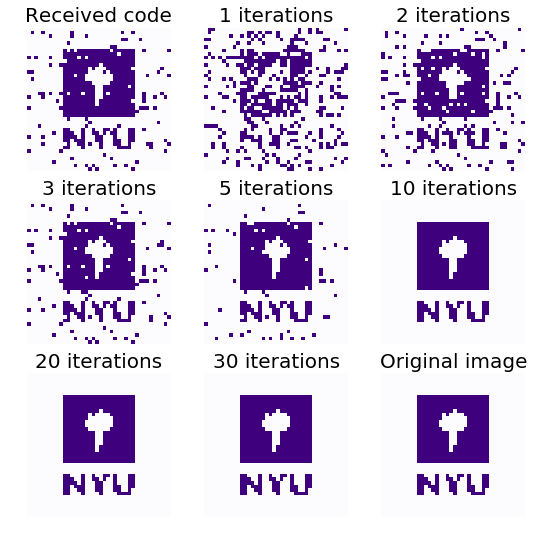

In [101]:
# Result plot
fig, axs = plt.subplots(3,3, figsize=(9, 9), facecolor='w', edgecolor='k')
axs = axs.reshape(-1)
iterations = [1,2,3,5,10,20,30]
ax0 = axs[0]
axs = axs[1:]
ax0.imshow(nyu_logo_codeword[:1600].reshape(40,40), cmap='Purples')
ax0.set_title('Received code', fontsize=20)
ax0.set_axis_off()
for i,prediction in enumerate(decoded_prediction):
    img_arr = prediction[:1600].reshape(40,40)
    axs[i].imshow(img_arr, cmap='Purples')
    axs[i].set_title('%d iterations'%iterations[i], fontsize=20)
    axs[i].set_axis_off()
axs[-1].imshow(nyu_logo_binary_compressed, cmap='Purples')
axs[-1].set_title('Original image', fontsize=20)
axs[-1].set_axis_off()

# Part f

In [108]:
# Generate codeword
nyu_logo_codeword = generate_codeword(nyu_logo_1600bit_message, sys_tG, error_rate=0.10)
# Decode
# Construct graph
fg_nyu_logo_codeword = construct_graph_with_H_and_observations(new_H, observations=nyu_logo_codeword, error_rate=0.10)
beliefs = get_beliefs(fg_nyu_logo_codeword, n_iteration=30, saving_iterations=[1,2,3,5,10,20])
decoded_prediction = decode_based_on_beliefs(beliefs)

100% (30 of 30) |#########################| Elapsed Time: 0:01:31 Time: 0:01:31


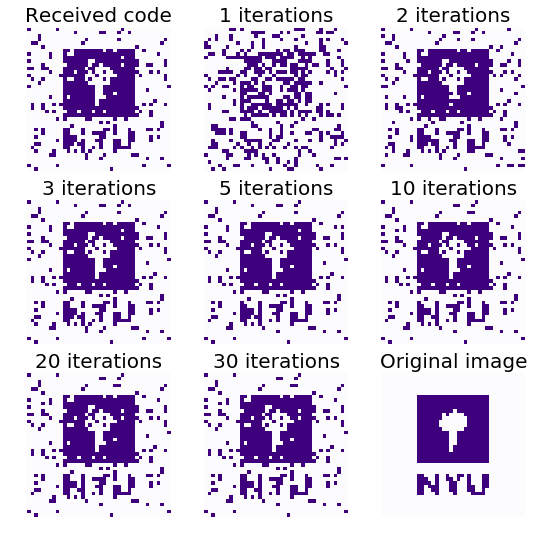

In [109]:
# Result plot
fig, axs = plt.subplots(3,3, figsize=(9, 9), facecolor='w', edgecolor='k')
axs = axs.reshape(-1)
iterations = [1,2,3,5,10,20,30]
ax0 = axs[0]
axs = axs[1:]
ax0.imshow(nyu_logo_codeword[:1600].reshape(40,40), cmap='Purples')
ax0.set_title('Received code', fontsize=20)
ax0.set_axis_off()
for i,prediction in enumerate(decoded_prediction):
    img_arr = prediction[:1600].reshape(40,40)
    axs[i].imshow(img_arr, cmap='Purples')
    axs[i].set_title('%d iterations'%iterations[i], fontsize=20)
    axs[i].set_axis_off()
axs[-1].imshow(nyu_logo_binary_compressed, cmap='Purples')
axs[-1].set_title('Original image', fontsize=20)
axs[-1].set_axis_off()